In [1]:
import tensorflow as tf
import pickle
import chess.engine
from ChessFunctions import *
import pandas as pd
import random
import gc

In [2]:
def choose_element_exponential(arr, scale_param):
    probabilities = np.exp(-scale_param * np.arange(len(arr)))
    probabilities /= probabilities.sum()  # Normalize probabilities to sum to 1
    chosen_index = np.random.choice(len(arr), p=probabilities)
    return arr[chosen_index]

In [3]:
model_old = tf.keras.models.load_model('old_model.h5')
model_new = tf.keras.models.load_model('new_model.h5')

replay_states = []
replay_scores = []

scale_param = 0.5
lambda_growth_rate = 1.05

with open('rewards.pkl', 'rb') as file:
    net_board_states = pickle.load(file)

In [4]:
# dice = [1,2,3,4,5,6]
# count = 10000
# results =  []
# for i in range(count):
#     results.append(choose_element_exponential(dice, 0.5*1.05**10))
# results.count(1)/count

In [5]:
games_to_play = 100

for i in range(games_to_play):

    board = chess.Board()
    net_board_state = []

    while True:

        # New model's turn
        old_board_score = stockfish(board, 10)
        moves = get_best_moves(board, model_new)
        move = choose_element_exponential(moves, scale_param)
        board.push(move)
        # display(board)
        if board.is_game_over():
            break
        ## Save game states and Stockfish score
        new_board_score = stockfish(board, 10)
        replay_states.append(split_dims(board))
        replay_scores.append(new_board_score)
        try:
            net_board_state.append((new_board_score - old_board_score) / 1973.0)
        except:
            pass

        # Old model's turn
        moves = get_best_moves(board, model_old)
        move = choose_element_exponential(moves, scale_param)
        board.push(move)
        # display(board)
        if board.is_game_over():
            break
        ## Save game states and Stockfish score
        replay_states.append(split_dims(board))
        replay_scores.append(stockfish(board, 10))
    
    # Updating model
    replay_scores = pd.Series(replay_scores)
    remove_indices = np.isnan(replay_scores)
    replay_states = np.stack(replay_states, axis=0)
    replay_states = replay_states[~remove_indices]
    replay_scores = replay_scores[~remove_indices]
    replay_scores = replay_scores.to_numpy() / 1973.0
    model_old = tf.keras.models.load_model('new_model.h5')
    model_new.fit(replay_states, replay_scores, epochs=1, batch_size=len(replay_scores), validation_split = 0.1)
    model_new.save("new_model.h5")

    # Updating and resetting variables
    replay_states = []
    replay_scores = []
    scale_param *= lambda_growth_rate
    net_board_states.append(np.mean(net_board_state))
    net_board_state = []

    with open("rewards.pkl", 'wb') as f:
        pickle.dump(net_board_states, f)

    print(f"Game {i + 1}/{games_to_play} complete")
    gc.collect()



1/1 [==============================] - 1s 725ms/step - loss: 0.0106 - val_loss: 0.0279
Game 1/100 complete
1/1 [==============================] - 0s 370ms/step - loss: 0.0501 - val_loss: 0.0508
Game 2/100 complete
1/1 [==============================] - 0s 386ms/step - loss: 0.0518 - val_loss: 1.5227e-23
Game 3/100 complete
1/1 [==============================] - 0s 376ms/step - loss: 0.0331 - val_loss: 0.1089
Game 4/100 complete
1/1 [==============================] - 0s 354ms/step - loss: 0.0376 - val_loss: 3.5494e-04
Game 5/100 complete
1/1 [==============================] - 0s 322ms/step - loss: 0.0585 - val_loss: 0.0776
Game 6/100 complete
1/1 [==============================] - 0s 446ms/step - loss: 0.0442 - val_loss: 0.1550
Game 7/100 complete
1/1 [==============================] - 0s 302ms/step - loss: 0.0810 - val_loss: 0.0907
Game 8/100 complete
1/1 [==============================] - 0s 320ms/step - loss: 0.0522 - val_loss: 0.0381
Game 9/100 complete
1/1 [========================

OSError: [WinError 1455] The paging file is too small for this operation to complete

Text(0.5, 0, 'Game')

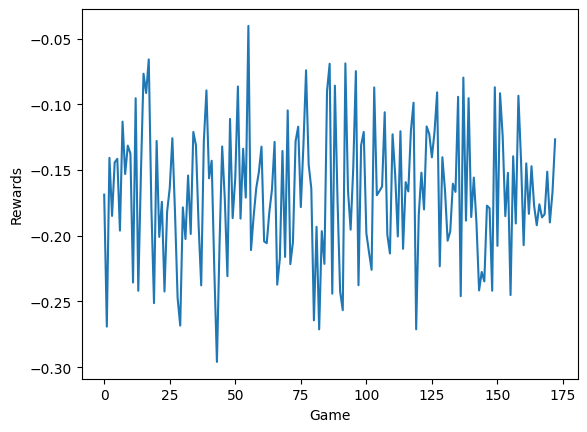

In [8]:
import matplotlib.pyplot as plt
plt.plot(net_board_states)
plt.ylabel("Rewards")
plt.xlabel("Game")